# Support Vector Machine I: The Linear Case

This is the first session dedicated to **Support Vector Machines (SVM)** — a powerful and widely used machine learning algorithm.

By the end of this session, you should be able to:

- Understand the concept of a **decision boundary**, its geometry, and how it can be used to classify data.
- Explain **hyperplane optimization** through the **maximum-margin principle**.
- Implement a **linear SVM from scratch using PyTorch**.
- Apply and evaluate an **SVM using `scikit-learn`**.

## 1. Linear Classification and Hyperplanes: Logistic Regression and LDA

Let us begin by generating some toy data where the classes are highly separable.

In [1]:
# Imports
import numpy as np
import matplotlib.pylab as plt
from sklearn.preprocessing import StandardScaler
# Let's create some toy data
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=20, n_features=2, n_informative=2, 
                           n_redundant=0, n_repeated=0, random_state=1234)


# This is to make data totally separable; see plot below
X[15, 1]=-1.4
X[6, 1] = -1.8
y_01 = y.copy()
y[y==0] = -1

<div class="alert alert-info">

📢❗🚨 𝐈𝐌𝐏𝐎𝐑𝐓𝐀𝐍𝐓 📢❗🚨
    
This session is going to be about Support Vector Machine. 

**This kind of algorithms are not scale invariant, so it is highly recommended to scale your data.**

**Remember**: In real-life applications, you should apply the same scaling to the test vector to obtain meaningful results. You may do this building Pipelines, as we saw in a previous lesson.

<div/>

In [2]:
# Scale data
X = StandardScaler().fit_transform(X)

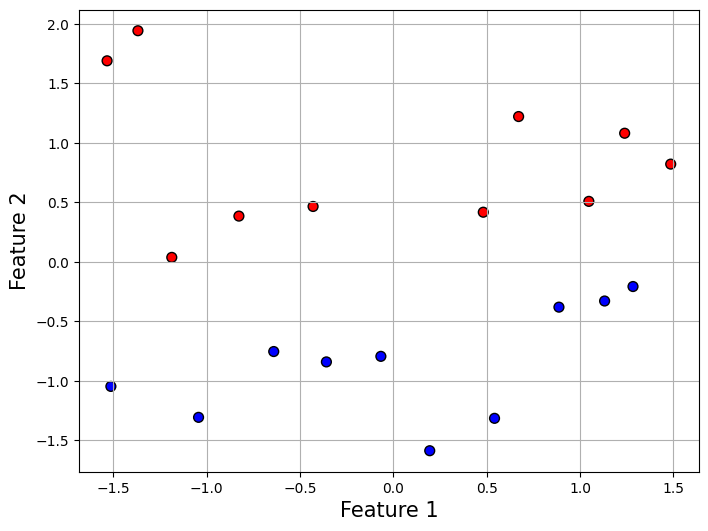

In [3]:
plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', s=50)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.grid(True)
plt.show()

Now, let us revisit **Logistic Regression** and **Linear Discriminant Analysis (LDA)** — two algorithms you have already seen in ML1:

- **Logistic Regression** estimates the probability of class membership without assuming any specific distribution for the features. It defines the decision boundary where the predicted probability of the positive class equals 0.5.

- **LDA** is a generative model that assumes normally distributed classes with equal covariance matrices. It finds the line (or hyperplane) that best separates the class distributions by maximizing the ratio of between-class variance to within-class variance.

Despite these differences, both models produce **linear decision boundaries** in the form of **hyperplanes** — straight lines in 2D and flat separating surfaces in higher dimensions.

**These decision boundaries divide the feature space into two regions: anything on one side will be classified as one class, and anything on the other side as the other class. The boundaries are entirely determined by the learned model parameters.**

Let us now fit both Logistic Regression and LDA, and visualize the decision boundaries they produce.

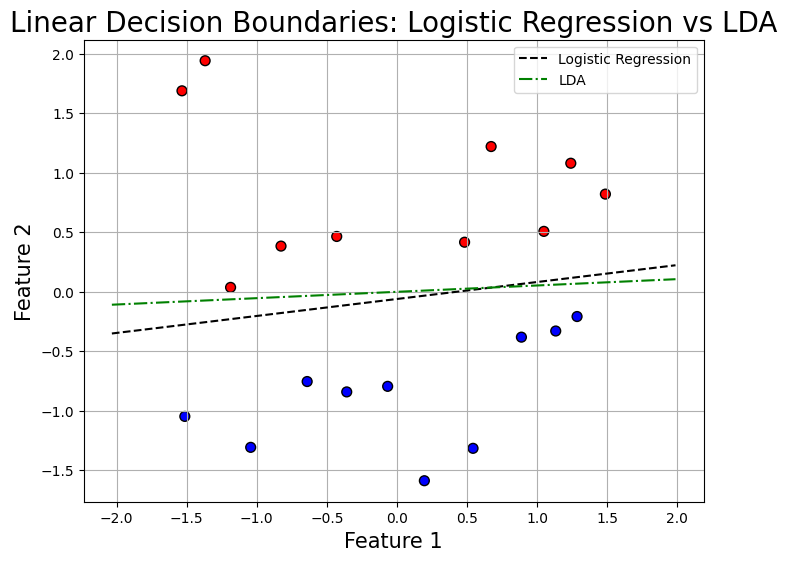

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Fit
log_reg = LogisticRegression().fit(X, y)
lda = LinearDiscriminantAnalysis().fit(X, y)

# Plotting the decision boundaries
xx = np.linspace(X[:,0].min() - 0.5, X[:,0].max() + 0.5, 100)
yy_log = -(log_reg.coef_[0,0] * xx + log_reg.intercept_[0]) / log_reg.coef_[0,1]
yy_lda = -(lda.coef_[0,0] * xx + lda.intercept_[0]) / lda.coef_[0,1]


plt.figure(figsize=(8, 6))
plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', s=50)
plt.plot(xx, yy_log, 'k--', label='Logistic Regression')
plt.plot(xx, yy_lda, 'g-.', label='LDA')
plt.legend()
plt.title("Linear Decision Boundaries: Logistic Regression vs LDA", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.grid(True)

So we have used LDA and Logistic Regression, which define decision boundaries based on probabilities or assumptions about the underlying data distribution.

But this raises an important question:

> What if we simply want to find a line that **separates** the classes, without relying on probabilistic reasoning or distributional assumptions?

This is precisely the goal of the **Support Vector Machine (SVM)**.

Unlike LDA and Logistic Regression, which use likelihoods or class probabilities, SVM takes a **purely geometric approach**. It looks for the hyperplane that **maximizes the margin** — that is, the distance to the nearest points from each class.

But, before jumping into how SVM does this, we need to introduce the notion of **distance to a hyperplane**.

## 2. Distance to a Hyperplane

The following equation defines a **hyperplane** in feature space:

$$
\sum_{j} x_{j} \cdot w_j + b = 0
$$

Any point $x_j$ that lies **on** this hyperplane satisfies this condition exactly.

Without loss of generality, we can use this hyperplane to classify data points. A point is assigned a class depending on which side of the hyperplane it lies. Assuming our class labels are $y_i \in \{-1, 1\}$, the classification rule becomes:

\begin{align}
\text{If} \;\; & y_i = 1 \quad \Rightarrow \quad \sum_{j} x_{ij} \cdot w_j + b > 0 \\
\text{If} \;\; & y_i = -1 \quad \Rightarrow \quad \sum_{j} x_{ij} \cdot w_j + b < 0
\end{align}

This can be written more compactly as:

$$
y_i \cdot \left( \sum_{j} x_{ij} \cdot w_j + b \right) > 0 \quad \text{for all } i
$$

Intuitively, the **larger** this value is, the **farther** the point is from the hyperplane — and the more confident we are in its classification. This motivates the idea that the quantity

$$
D(b, w_j) = y_i \cdot \left( \sum_{j} x_{ij} \cdot w_j + b \right)
$$

can be interpreted as a kind of **signed distance** to the hyperplane. A positive value means the point lies on the correct side of the boundary; a negative value indicates misclassification.

## 3. Building Intuition with Classifying Hyperplanes: The Perceptron

For a given point $(x_ij, y_i)$, any missclasified point results in $D(b, w_j) < 0$. In other words, any misclassified point lies on the wrong side of the hyperplane or exactly on it — resulting in a **non-positive signed distance**.

Our goal is to find parameters $(w_j, b)$ such that this **does not** happen — that is, such that all training points are correctly classified.

This is the basic idea behind the **Perceptron model**, which you have already studied in ML1.

The perceptron tries to find a separating hyperplane that minimizes this distance, i.e. the misclassified points to the decision boundary. This achieved through the following learning rule:

$$
\text{if } y_i \cdot \left( \sum_{j} x_{ij} \cdot w_j + b \right) \leq 0:
\quad
w_j \leftarrow w_j + y_i \cdot x_{ij}, \quad b \leftarrow b + y_i
$$

This rule updates $(w_j, b)$ each time a point is misclassified, gradually shifting the decision boundary toward correct separation.

Let us now implement this model in `PyTorch`.

In [5]:
import torch

class Perceptron():

    def __init__(self, num_features, learning_rate=0.01):
        self.learning_rate = learning_rate
        self.w = torch.randn(num_features, dtype=torch.float, requires_grad=False)
        self.b = torch.randn(1, dtype=torch.float, requires_grad=False)

    # Forward defines the computation in the model
    def forward(self, x):
        # Handle both single sample (1D) and batch (2D)
        if x.dim() == 1:
            return torch.sign(torch.dot(x, self.w) + self.b)
        else:
            return torch.sign(x @ self.w + self.b)

    def train(self, X, y, epochs):

          for epoch in range(epochs):
            
            errors = 0

            for i in range(len(y)):
                d = y[i] * self.forward(X[i])                
                if d <= 0:  # misclassified or on the boundary
                    self.w += self.learning_rate * y[i] * X[i]
                    self.b += self.learning_rate * y[i]
                    errors += 1

    def predict(self, X):
        return self.forward(X)

And let us test the model on the same toy dataset we used earlier. We will do this running  the perceptron  multiple times using different random initialization seeds to see the resulting decision boundaries:

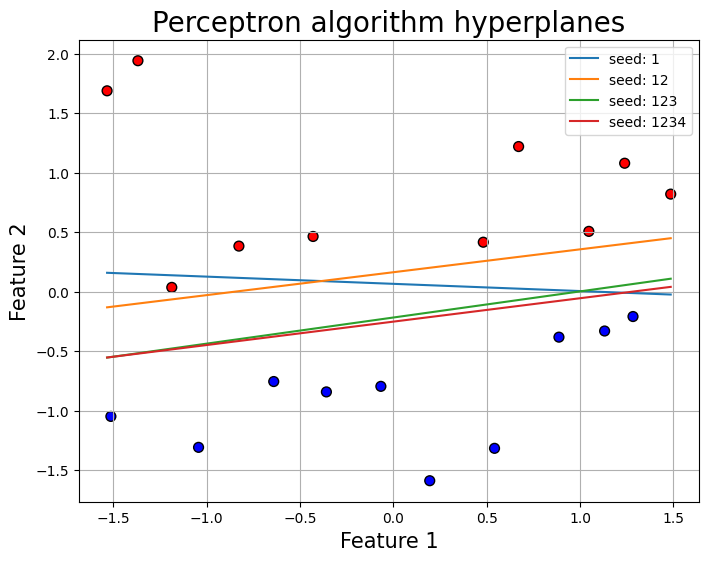

In [6]:
# Convert toy dataset to tensors
X = torch.tensor(X, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)

xmin, xmax = X.numpy()[:,0].min(), X.numpy()[:,0].max()

plt.figure(figsize=(8, 6))

plt.scatter(X[:,0], X[:,1], c=y, cmap='bwr', edgecolor='k', s=50)

xs = np.linspace(xmin, xmax, 100)
for seed in [1, 12, 123, 1234]:
    torch.manual_seed(seed) 

    model = Perceptron(num_features=2, learning_rate=0.01)

    model.train(X, y, epochs=100)
    ys = [(-model.w.numpy()[0]*x - -model.b.numpy()[0])/model.w.numpy()[1] for x in xs]
    plt.plot(xs, ys, label=f"seed: {seed}")
    
plt.legend()

plt.title("Perceptron algorithm hyperplanes", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.grid(True)


As you can see, even when the data is linearly separable, there are **many possible separating hyperplanes** — and which one the Perceptron finds depends on the initial values.

The **problem** is that the Perceptron updates the decision boundary until it finds *some* hyperplane that separates the data. But it doesn't care **how close** the points are to the boundary — a point just needs to be on the correct side. 

A natural solution is to change **how** we choose the separating hyperplane, using not just class labels but also the **geometry (distance) of the data**.

This is exactly where the **Support Vector Machine (SVM)** comes in.

## 4. Support Vector Machine: Classification Based on Maximum-Margin Hyperplanes

The **Support Vector Machine (SVM)** aims to find a hyperplane that not only separates the data, but also **maximizes the margin** — that is, the distance between the closest points of each class to the hyperplane.

Maximizing this margin tends to improve generalization and performance on unseen data, making SVM a powerful and widely used classifier.

As mentioned earlier, a linear hyperplane is defined by:

$$
\sum_{j} w_j \cdot x_{ij} + b = 0
$$

We classify points based on which side of the hyperplane they fall:

- $ \sum_{j} w_j \cdot x_{ij} + b > 0 \;$ → one class  
- $ \sum_{j} w_j \cdot x_{ij} + b < 0 \;$ → the other class  

The farther the value is from zero, the farther the point lies from the hyperplane.

---

Now, let us assume that the **closest point** from each class lies at a distance \( c \) from the hyperplane. We then define two **margin boundaries**:

- $ \sum_{j} w_j \cdot x_{ij} + b = +c \;$ if \( $y_i$ = 1 \)  
- $ \sum_{j} w_j \cdot x_{ij} + b = -c \;$ if \( $y_i$ = -1 \)

These are two **parallel hyperplanes** placed symmetrically around the decision boundary. Every point must lie on the correct side of its margin, yielding the constraint:

$$
y_i \cdot \left( \sum_{j} w_j \cdot x_{ij} + b \right) \geq c \quad \text{for all } i
$$

The distance between the two margin boundaries is:

$$
\frac{2c}{\|w\|}, \quad \text{where } \|w\| = \sqrt{\sum_j w_j^2}
$$

---

Since $c$ is an arbitrary scaling constant, we can set $c = 1$ without loss of generality. This simplifies the constraint to:

$$
y_i \cdot \left( \sum_{j} w_j \cdot x_{ij} + b \right) \geq 1
$$

So that's it! What SVM does is:

- It **maximizes the margin**, which is equivalent to **minimizing** \( \|w\| \)
- **Subject to** all points being on the correct side of the margin.

But, to make this a convex optimization problem, we minimize $||w||^2$, instead of $||w||$, therefore:

$$
\min \frac{1}{2} \|w\|^2 \quad \text{subject to } y_i \cdot \left( \sum_{j} w_j \cdot x_{ij} + b \right) \geq 1
$$

---

Let us now see how all of this works in practice using our toy dataset.

We will use the `LinearSVC` class — the scikit-learn implementation of **Support Vector Classification**, found in the `sklearn.svm` module.

Before proceeding, take a moment to explore the documentation for this class and its parameters:

[Documentation of LinearSVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html)

In particular, pay attention to the following parameter:

- `C`: the regularization parameter. A very large value (e.g., `C=10000`) approximates a **hard-margin** SVM. We will soon see how this regularization arises and what role it plays.

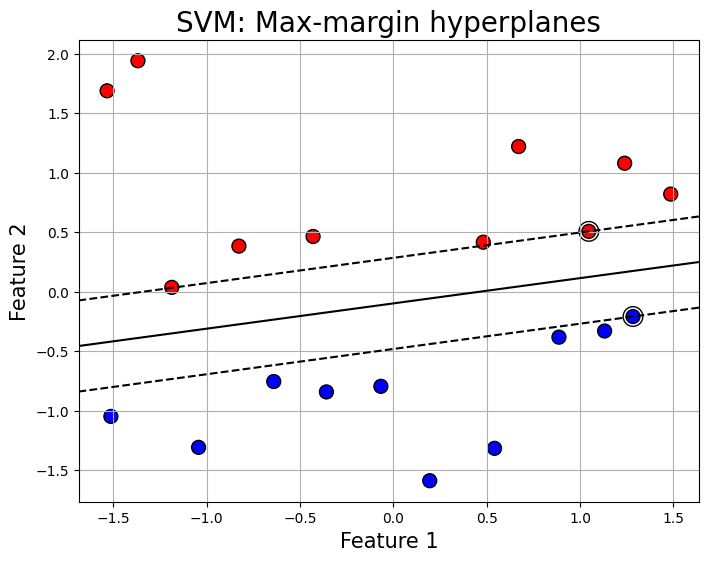

In [7]:
from sklearn.svm import LinearSVC

# For now do not worry about these hyperparameter values
clf = LinearSVC(C=10000, loss="hinge")  
clf.fit(X.numpy(), y_01)

# Identify the support vectors. See below
support_vector_indices = (np.abs(clf.decision_function(X.numpy())) <= 1 + 1e-15).nonzero()[0]
support_vectors = X[support_vector_indices]

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=100, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--','-','--'])
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], 
            s=200, linewidth=1, facecolors='none', edgecolors='k')
plt.title("SVM: Max-margin hyperplanes", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.grid(True)


The highlighted points are called **support vectors** and they are the set points that completely determine the max-margin hyperplanes.

## 5. Non-separable case: soft-margin separation

The previous description of SVM only works when the classes are **perfectly separable**, as in our earlier toy dataset. 

However, in real-world scenarios, classes often **overlap**, making it impossible to find a hyperplane that separates them cleanly with a margin.

To handle this, we need to "soften" the margins by allowing some points to fall on the wrong side of the margins. This is done by allowing the margins, for all points, to move slightly by a given positive constant $\xi_i$, usually called **slack variables**:

$$y_i\cdot(\sum_{j}w_j\cdot x_{ij} + b) \geq 1 - \xi_i$$

(As before, we set $c = 1$ without loss of generality.)

---

### Reformulated Optimization Problem

Then, the new optimization problem becomes:

\begin{align}
\min_{w, b, \xi} \quad & \|w\|^2 + C \cdot \sum_i \xi_i \\
\text{subject to} \quad & y_i \cdot \left( \sum_{j} w_j \cdot x_{ij} + b \right) \geq 1 - \xi_i, \quad \xi_i \geq 0
\end{align}

Where $C$ is some penalty to control for how much flexibility we allow for our separating margins.

<div class="alert alert-warning">

🚨📢🔔⚠️ **REMEMBER** 🚨📢🔔⚠️
    
$C$ is a **hyperparameter** , so it must be tuned, typically via cross-validation.

</div>

### Cost function

Now, we are not going to demonstrate it (see Exercise 12.1 in course material *C*), but this is equivalent to considering minimizing the following cost function:

$$
J(w, b) = \; \underbrace{ \sum_i \left[1 - y_i \cdot (\sum_j x_{ij} w_j + b) \right]^+ }_{\text{loss}} + \underbrace{ \frac{1}{2C} \|w\|^2 }_{\text{Regularization}}
$$
where the superscript “+” indicates positive part. 


---

The structure of this cost function should look familiar: it is the classic **"loss + regularization"** form that appears in many machine learning models.

In this cost function: 

- Thee loss penalizes incorrect predictions.
- The regularization part keeps weights small.

### Hinge Loss

The loss in the previous cost function $J(w, b)$ is called the **hinge loss**. To build some intuition around it, let us visualize how it behaves.

For simplicity, let’s assume $y_i = 1 $ for all $i$. In that case, the hinge loss reduces to:

$$
\text{hinge}(z) = \max(0, 1 - z), \quad \text{where } z = \sum_{j}x_{ij} \cdot w_j + b
$$

Let’s plot it!

Text(0.5, 0, 'Distance')

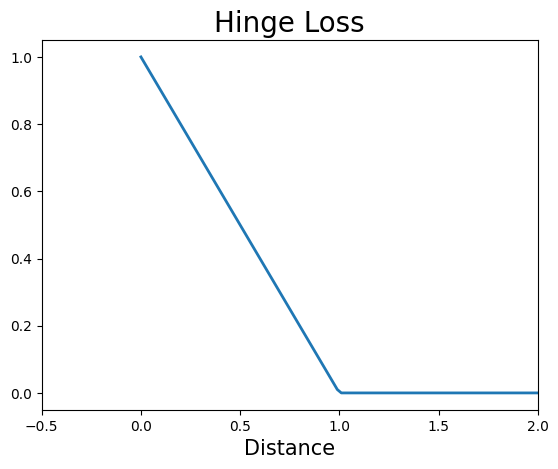

In [8]:
def hinge_loss(z):
    return np.maximum(1 - z, 0)

xs = np.linspace(0, 2, 100)
plt.plot(xs, hinge_loss(xs), linewidth=2)
plt.title("Hinge Loss", size=20)
plt.xlim([-0.5, 2])
plt.xlabel("Distance", size=15)

Several observations from this plot:

- For $y_i = 1$, a value of $\sum_{j}w_j \cdot x_{ij} + b \geq 1$ corresponds to a point that lies **on the correct side of the margin** or even farther. These points are correctly classified **with room to spare**, so their loss is **zero** — exactly what we want!

- If $\sum_{j} w_j \cdot x_{ij} + b < 1$, the point is **within the margin**. These are the cases we want to penalize — so the hinge loss is **positive**.

- The penalization is **linear**: the farther a point is on the wrong side of the margin, the larger the penalty. This creates a natural incentive to push points away from the margin and into the correct region.

This makes hinge loss both intuitive and effective for classification with linear boundaries.

Let's see all this in action by making our toy data not totally separable. For that, we'll just move one point around:

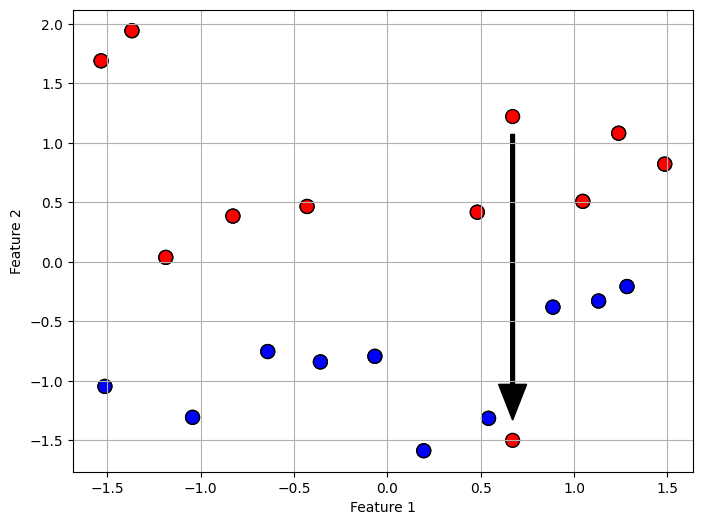

In [9]:
X_nonsep, y_nonsep = X.clone(), y.clone()

X_nonsep[0, 1]=-1.5 # Move one red point to the blue zone

plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='bwr', s=100, edgecolors='k')
plt.scatter(X_nonsep[:, 0], X_nonsep[:, 1], c=y_nonsep, cmap='bwr', s=100, edgecolors='k')
plt.arrow(X[0,0].item(), X[0,1].item() - 0.15, 0, -2.1, width=0.02, head_width=0.15, head_length=0.3, fc='k')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.grid(True)

And run SVM in this scenario: 

In [10]:
y_nonsep_01 = y_nonsep.clone()
y_nonsep_01[y_nonsep_01==-1] = 0

/home/javi/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1235: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


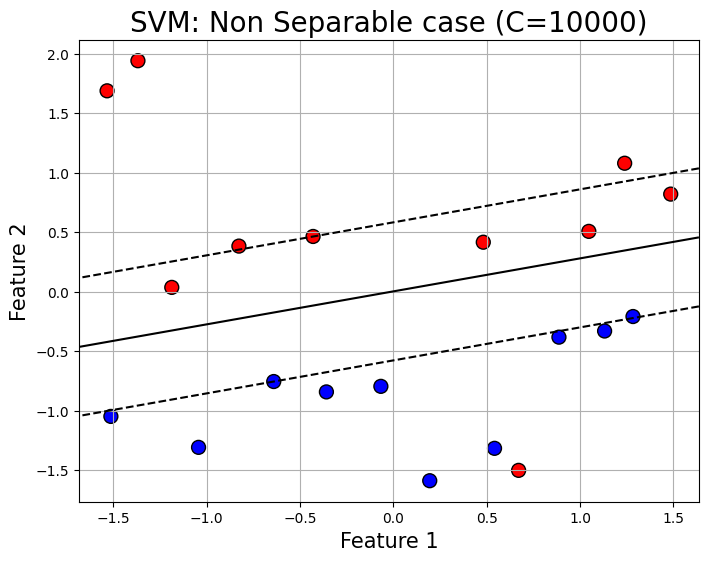

In [11]:
clf = LinearSVC(C=10000, loss="hinge")
clf.fit(X_nonsep.numpy(), y_nonsep_01.numpy())

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_nonsep[:, 0], X_nonsep[:, 1], c=y, cmap='bwr', s=100, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--','-','--'])
plt.title("SVM: Non Separable case (C=10000)", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.grid(True)

As you can see, `LinearSVC` complains about failing to converge and the performance, looking at the number of points lying in the wrong side of the margins, does not look good. But this is perfectly fine in this case (and expected)!

Why? Because the data is not (linearly( separable, and we are setting $C$ to a very large value — effectively enforcing a hard-margin classification.

So the classifier is trying to find a separating hyperplane with zero classification error, which is impossible when overlap exists in the data. As a result, the optimization struggles, and the model may not converge.

Let's see what happens when we decrease the value of $C$, allowing the margins to be more flexible:

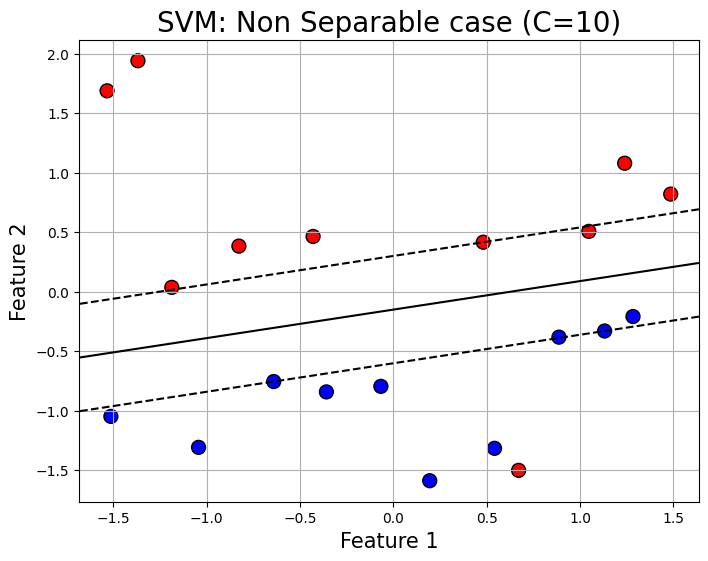

In [12]:
clf = LinearSVC(C=10, loss="hinge")
clf.fit(X_nonsep.numpy(), y_nonsep_01.numpy())

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_nonsep[:, 0], X_nonsep[:, 1], c=y, cmap='bwr', s=100, edgecolors='k')

ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = clf.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], linestyles=['--','-','--'])
plt.title("SVM: Non Separable case (C=10)", size=20)
plt.xlabel("Feature 1", size=15)
plt.ylabel("Feature 2", size=15)
plt.grid(True)

**Nice!** Now the algorithm has converged and appears to perform much better, as indicated by the reduced number of misclassified points. This is due to the **regularization term**, which relaxes the requirement for perfectly separable margins and allows the model to tolerate some classification errors — a crucial feature when working with non-separable data.

## 7. Summary

- **Support Vector Machines (SVMs)** aim to maximize the **geometric margin**, leading to better generalization.  
- Only the **support vectors** — the points closest to the decision boundary — influence the final model.  
- The **regularization parameter** controls margin flexibility, thereby allowing the model to handle non-separable data.  

In the next lesson, we will extend SVMs to handle **non-linear** decision boundaries using the **kernel trick**!

## 8. 📝 Exercises

### 8.1 Exercise — Implementing SVM with `PyTorch` and SGD

In this exercise, you will implement the Support Vector Machine classifier using `PyTorch` and Stochastic Gradient Descent (SGD).

This implementation is not meant to replace `LinearSVC` from `scikit-learn`, but rather to reinforce your understanding of how optimization works under the hood using `PyTorch`.

To help you, I will provide the structure of the class and key components — your task is to complete the missing parts and experiment with the result.

1. Plot the Hinge Loss Function. Below I am providing you the hinge loss part of the cost function. Your job is to visualize it to make sure it has the correct shape:

In [13]:
def hinge_loss(y_pred, y_true):
    return torch.mean(torch.clamp(1 - y_pred * y_true, min=0))

In [14]:
# YOUR CODE

2. Modify below code to fill the gaps in the given class implementing SVM and Stochastic Gradient Descent.

In [15]:
class PytorchSVM():

    def __init__(self, num_features, C=1, learning_rate=0.1):
        self.C = C
        self.w = torch.randn(num_features, dtype=torch.float, requires_grad=True)
        self.b = torch.randn(1, dtype=torch.float, requires_grad=True)
        self.lr = learning_rate

    def forward(self, x):
        if x.dim() == 1:
            return torch.dot(x, self.w) + self.b
        else:
            return x @ self.w + self.b

    def fit(self, X, y, n_epochs=100):
        n_obs = X.shape[0]
        for epoch in range(n_epochs):
            indices = torch.randperm(n_obs)
            X_shuffled = X[indices]
            y_shuffled = y[indices]

            for i in range(n_obs):
                x_i = X_shuffled[i]
                y_i = y_shuffled[i]
                y_pred = self.forward(x_i)

                # TODO: Complete this block
                # 1. Compute hinge loss (You should the one I gave you above)
                # 2. Compute L2 regularization
                # 3. Combine into total cost
                # 4. Backward pass and update weights (You may reuse the same code that we used in the regularization lesson)

                pass  # remove when filled in

        return self

    def predict(self, X):
        with torch.no_grad():
            return torch.sign(self.forward(X))


3. Instantiate your `PytorchSVM` model, setting `C=1` and `learning_rate=0.01`. Then fit it on any of the toy datasets used earlier in the lesson and plot the resulting decision boundary.

- Are the results similar to those obtained with `LinearSVC`?
- How sensitive is the model to the choice of learning rate and number of epochs?

In [16]:
# YOUR CODE

---

### 📝 8.1: Effect of Regularization Strength on the Margin

In this exercise, you will explore how the regularization parameter **C** affects the decision boundary and the margin.

Using `LinearSVC` from `scikit-learn` and the same non-separable toy dataset in this lesson, do the following:

1. Fit a `LinearSVC` model using each of the following values of `C`:  [0.001, 0.01, 0.1, 1]

2. For each value of `C`, plot:
   - The decision boundary.
   - The margin (you can highlight the support vectors if you'd like).

3. Discuss your observations:
   - How does the decision boundary change with different values of `C`?
   - What happens to the margin width?
   - How does the number of misclassified points vary?

In [17]:
# YOUR CODE